In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite

engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables

Base.prepare(autoload_with=engine)


In [6]:
# View all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table

measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB

session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Get columns

inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Find the most recent date in the data set.

most_recent = session.query(measurement.date).order_by(measurement.date.desc()).first()

most_recent

('2017-08-23',)

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

year_earlier = dt.date.fromisoformat(most_recent[0]) - dt.timedelta(days=365)

print(f"Date one year earlier than most recent is: {year_earlier}")

# Perform a query to retrieve the data and precipitation scores

last_year_data = session.query(measurement.date, measurement.prcp).\
                  filter(measurement.date > year_earlier).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

last_year_df = pd.DataFrame(last_year_data)

last_year_df = pd.DataFrame(last_year_data).set_index('date')

last_year_df.index = pd.to_datetime(last_year_df.index)

# Sort the dataframe by date

last_year_df.sort_values(by='date', inplace = True)

last_year_df.head()


Date one year earlier than most recent is: 2016-08-23


,prcp
date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15


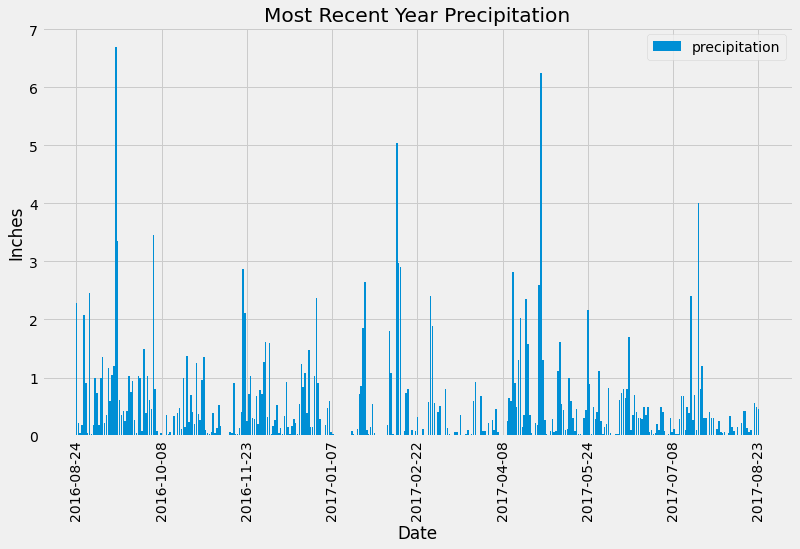

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data

# Note: Used plt.bar instead of df.plot.bar since it was significantly faster

x_ticks = pd.date_range(start=last_year_df.index.min(),end=last_year_df.index.max(), periods = 9)


fig, ax = plt.subplots(figsize=[12,7])
ax = plt.bar(last_year_df.index,last_year_df['prcp'])
plt.xticks(ticks = x_ticks, rotation = 90)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Most Recent Year Precipitation')
plt.legend(['precipitation'],loc='upper right')
plt.show()


In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data

last_year_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Get columns

inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
# Design a query to calculate the total number stations in the dataset

# Number of stations from Station table

num_stations_1 = session.query(station.id).count()

# Number of stations from Measurements table

num_stations_2 = session.query(measurement.station).group_by(measurement.station).count()

print (f"The number of stations from the Stations Table is: {num_stations_1}")
print (f"The number of stations from the Measurments Table is: {num_stations_2}")

The number of stations from the Stations Table is: 9
The number of stations from the Measurments Table is: 9


In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

sel = [func.count(measurement.station), station.station, station.name]
most_active_list = session.query(*sel).\
    filter(measurement.station == station.station).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).\
    all()

print ('The stations in order of activity is (Measurments, ID, Name):\n')

for row in most_active_list:
    print(row)


The stations in order of activity is (Measurments, ID, Name):

(2772, 'USC00519281', 'WAIHEE 837.5, HI US')
(2724, 'USC00519397', 'WAIKIKI 717.2, HI US')
(2709, 'USC00513117', 'KANEOHE 838.1, HI US')
(2669, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US')
(2612, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US')
(2202, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US')
(1979, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US')
(1372, 'USC00517948', 'PEARL CITY, HI US')
(511, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US')


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

sel2 = [measurement.station, station.name, func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)]
most_active_station = session.query(*sel2).\
    filter(measurement.station == station.station).\
    filter(measurement.station == most_active_list[0][1]).\
    all()

print(f'{most_active_station}\n')

print(f'Most active station information:\n'
      f'ID: {most_active_station[0][0]}\n'
      f'Name: {most_active_station[0][1]}\n'
      f'Min Temp: {most_active_station[0][2]}\n'
      f'Max Temp: {most_active_station[0][3]}\n'
      f'Avg Temp: {round(most_active_station[0][4], 2)}')

[('USC00519281', 'WAIHEE 837.5, HI US', 54.0, 85.0, 71.66378066378067)]

Most active station information:
ID: USC00519281
Name: WAIHEE 837.5, HI US
Min Temp: 54.0
Max Temp: 85.0
Avg Temp: 71.66


In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

station_year = session.query(measurement.tobs).\
    filter(measurement.station == most_active_station[0][0]).\
    filter(measurement.date > year_earlier).\
    all()

station_year_df = pd.DataFrame(station_year)

station_year_df.head()


,tobs
0,77.0
1,80.0
2,80.0
3,75.0
4,73.0


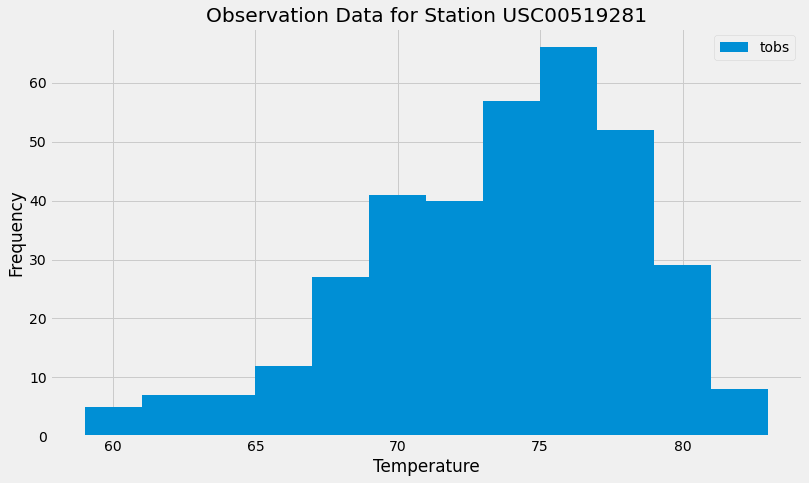

In [19]:
# Plot results as a histogram

fig, ax = plt.subplots(figsize=[12,7])
ax = plt.hist(station_year_df,bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title(f'Observation Data for Station {most_active_station[0][0]}')
plt.legend(['tobs'],loc='upper right')
plt.show()

# Close session

In [20]:
# Close Session
session.close()